# Who needs models, just do statstics
First of all, 95% of the kernel is stolen from Chris, I just exchanged QDA with heuristic statistics. The main point is, that if we assume our variables to be multivariate normal distributed (which we know from the make_classification function) we can just calcuate the probability that a data point belongs to either of the two ellipses by calculating probablities.

# Intro
Luckily Chris already put some illustrative pictures in his kernel, I can steal.
Here is a pictorial explanation using sythetic 2D data. 
  
## Step 1 - Build first model
Given 50 training observations (25 target=1 yellow points, 25 target=0 blue points) we can estimate the multivariate (approx 40 dimensions) normal distributions of each of the two target types (0 & 1) by calculating empiral covariance and mean (see np.cov and np.mean) and then calculate that a given datapoint belongs to distribution A or B using scipy.stats.multivariate.


![image](http://playagricola.com/Kaggle/p16419.png)

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html#scipy.stats.multivariate_normal
https://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html


# Apply Statistics to Instant Gratification Comp
## Load Data

In [1]:
import numpy as np, pandas as pd, os
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

train.head()

,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
0,707b395ecdcbb4dc2eabea00e4d1b179,-2.070654,1.018160,0.228643,0.857221,0.052271,0.230303,-6.385090,0.439369,-0.721946,-0.227027,0.575964,1.541908,1.745286,-0.624271,3.600958,1.176489,-0.182776,-0.228391,1.682263,-0.833236,-4.377688,-5.372410,-0.477742,-0.179005,-0.516475,0.127391,-0.857591,-0.461500,2.160303,-2.118371,0.515493,-1.201493,-0.027377,-1.154024,0.753204,-0.179651,-0.807341,-1.663626,0.893806,...,-1.829848,2.347131,0.082462,-1.012654,0.593752,2.904654,-0.428974,-0.919979,2.849575,-0.906744,0.729459,0.386140,0.319814,-0.407682,-0.170667,-1.242919,-1.719046,-0.132395,-0.368991,-5.112553,-2.085988,-0.897257,1.080671,-0.273262,0.342824,0.640177,-0.415298,-0.483126,-0.080799,2.416224,0.351895,0.618824,-1.542423,0.598175,0.611757,0.678772,0.247059,-0.806677,-0.193649,0
1,5880c03c6582a7b42248668e56b4bdec,-0.491702,0.082645,-0.011193,1.071266,-0.346347,-0.082209,0.110579,-0.382374,-0.229620,0.783980,-1.280579,-1.003480,-7.753201,-1.320547,0.919078,-1.036068,0.030213,0.910172,-0.905345,0.646641,-0.465291,-0.531735,-0.756781,0.193724,0.224277,-0.474412,1.885805,0.205439,-6.481422,1.035620,-0.453623,0.375936,-0.320670,-0.144646,-0.220129,0.577826,-0.360512,-0.600107,0.008111,...,0.982205,-1.161978,0.532269,1.133215,0.003503,-1.390962,0.158572,0.143794,-0.317185,1.017192,-0.395342,-0.642357,-0.627209,0.257271,-1.461564,0.325613,1.628369,0.640040,0.750735,1.164573,0.900373,0.063489,0.948158,0.273014,-1.269147,-0.251101,-2.271731,-0.044167,-0.443766,-1.144794,-0.645115,-1.246090,2.613357,-0.479664,1.581289,0.931258,0.151937,-0.766595,0.474351,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,-1.680473,0.860529,-1.076195,0.740124,3.678445,0.28855

# The 2 main functions: Emperical Covariance and calculate probability

The next functions calculates empirical covariance and mean using numpy per label type and returns the two multivariate normal distibutions as instance.  

In [2]:
from scipy.stats import multivariate_normal

def get_mv(x,y):
    ones = (y==1).astype(bool)
    x2 = x[ones]
    cov1 = np.cov(x2.T)
    m1 = np.mean(x2, axis = 0)
    
    zeros = (y==0).astype(bool)
    x2b = x[zeros]
    cov2 = np.cov(x2b.T)
    m2 = np.mean(x2b, axis = 0)
    
    mv1 = multivariate_normal(mean=m1, cov=cov1)
    mv2 = multivariate_normal(mean=m2, cov=cov2)
    
    return mv1, mv2



The second function calculates the probability that a datapoint belongs to a multivariate normal distribution given two alernatives. first we calculate the probability for a specific datapoint to come from each of the two multivariate distributions using `multivariate_normal.pdf`. Then we use bayes formula to get the overall probabiity. See e.g. https://math.stackexchange.com/questions/825455/probability-that-a-sample-comes-from-one-of-two-distributions

In [3]:
def calc_prob(x,mv1,mv2):
    y_pred2 = np.zeros((len(x),))
    for i in range(len(x)):
        a = mv1.pdf(x[i])
        b = mv2.pdf(x[i])
        y_pred2[i] = a/(a+b)
    return y_pred2

In [4]:
# INITIALIZE VARIABLES
cols = [c for c in train.columns if c not in ['id', 'target']]
cols.remove('wheezy-copper-turtle-magic')
oof = np.zeros(len(train))
preds = np.zeros(len(test))

# BUILD 512 SEPARATE MODELS
for i in tqdm(range(512)):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])
    
    # STRATIFIED K-FOLD
    skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train3, train2['target']):
        
        # MODEL AND PREDICT WITH QDA
        #clf = QuadraticDiscriminantAnalysis(reg_param=0.5)
        
        
        mv1, mv2 = get_mv(train3[train_index,:],train2.loc[train_index]['target'].values)
        oof[idx1[test_index]] = calc_prob(train3[test_index,:],mv1,mv2)
        preds[idx2] += calc_prob(test3,mv1,mv2)/ skf.n_splits
       
    #if i%64==0: print(i)
        
# PRINT CV AUC
auc = roc_auc_score(train['target'],oof)
print('QDA scores CV =',round(auc,5))

100%|██████████| 512/512 [01:53<00:00,  4.59it/s]

QDA scores CV = 0.96504


# Step 3 & 4 - Add pseudo label data and recalculate 

Same as in the original kernel we use pseudlabelling...

In [5]:
# INITIALIZE VARIABLES
test['target'] = preds
oof = np.zeros(len(train))
preds = np.zeros(len(test))

# BUILD 512 SEPARATE MODELS
for k in tqdm(range(512)):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==k] 
    train2p = train2.copy(); idx1 = train2.index 
    test2 = test[test['wheezy-copper-turtle-magic']==k]
    
    # ADD PSEUDO LABELED DATA
    test2p = test2[ (test2['target']<=0.01) | (test2['target']>=0.99) ].copy()
    test2p.loc[ test2p['target']>=0.5, 'target' ] = 1
    test2p.loc[ test2p['target']<0.5, 'target' ] = 0 
    train2p = pd.concat([train2p,test2p],axis=0)
    train2p.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2p[cols])     
    train3p = sel.transform(train2p[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])
        
    # STRATIFIED K FOLD
    skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train3p, train2p['target']):
        test_index3 = test_index[ test_index<len(train3) ] # ignore pseudo in oof
        
        mv1, mv2 = get_mv(train3p[train_index,:],train2p.loc[train_index]['target'].values)
        oof[idx1[test_index3]] = calc_prob(train3[test_index3,:],mv1,mv2)
        preds[test2.index] += calc_prob(test3,mv1,mv2) / skf.n_splits

       
    #if k%64==0: print(k)
        
# PRINT CV AUC
auc = roc_auc_score(train['target'],oof)
print('Pseudo Labeled QDA scores CV =',round(auc,5))

100%|██████████| 512/512 [02:03<00:00,  4.11it/s]

Pseudo Labeled QDA scores CV = 0.97027


# Submit Predictions

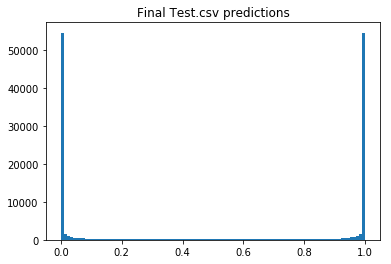

In [6]:
sub = pd.read_csv('../input/sample_submission.csv')
sub['target'] = preds
sub.to_csv('submission.csv',index=False)

import matplotlib.pyplot as plt
plt.hist(preds,bins=100)
plt.title('Final Test.csv predictions')
plt.show()

# Conclusion
In this kernel, we learned what pseudo labeling is, why it works, and how to deploy it. Using it on the data from Instant Gratification competition we observed it increase CV by an impressive 0.005! Pseudo labeling QDA achieved CV 0.970 and LB 0.969. Without pseudo labeling, QDA achieved CV 0.965 and LB 0.965.

When you run your kernel locally, it will only pseudo label the public test data (because that is all that `test.csv` contains). When you submit this solution to Kaggle, your submission will load the full `test.csv` and pseudo label both the public and private test data set. Thus you will approximately double your amount of training data for your submissions!